<a href="https://www.kaggle.com/code/jlcordoba/birdclef-notebook-pplu?scriptVersionId=92989650" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import json
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
#reading CSV with pandas
Taxonomy = pd.read_csv('../input/birdclef-2022/eBird_Taxonomy_v2021.csv')
test = pd.read_csv('../input/birdclef-2022/test.csv')
train_metadata = pd.read_csv('../input/birdclef-2022/train_metadata.csv')
submission = pd.read_csv('../input/birdclef-2022/sample_submission.csv')
from os import path
from pydub import AudioSegment
import seaborn as sns

# files
src = "../input/birdclef-2022/train_audio/afrsil1/XC395771.ogg"#this audio have 4.5 rating
dst = "/kaggle/working/XC395771.wav"

# convert ogg to wav
sound = AudioSegment.from_ogg(src)
sound.export(dst, format="wav")

#transform into dataframe
df_taxonomy = pd.DataFrame(Taxonomy)

df_test = pd.DataFrame(test)

df_train = pd.DataFrame(train_metadata)

df_submission = pd.DataFrame(submission)

df_taxonomy.head()







# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

,TAXON_ORDER,CATEGORY,SPECIES_CODE,PRIMARY_COM_NAME,SCI_NAME,ORDER1,FAMILY,SPECIES_GROUP,REPORT_AS
0,1,species,ostric2,Common Ostrich,Struthio camelus,Struthioniformes,Struthionidae (Ostriches),Ostriches,NaN
1,6,species,ostric3,Somali Ostrich,Struthio molybdophanes,Struthioniformes,Struthionidae (Ostriches),NaN,NaN
2,7,slash,y00934,Common/Somali Ostrich,Struthio camelus/molybdophanes,Struthioniformes,Struthionidae (Ostriches),NaN,NaN
3,8,species,grerhe1,Greater Rhea,Rhea americana,Rheiformes,Rheidae (Rheas),Rheas,NaN
4,14,species,lesrhe2,Lesser Rhea,Rhea pennata,Rheiformes,Rheidae (Rheas),NaN,NaN


In [2]:
df_test.head()

,row_id,file_id,bird,end_time
0,soundscape_1000170626_akiapo_5,soundscape_1000170626,akiapo,5
1,soundscape_1000170626_akiapo_10,soundscape_1000170626,akiapo,10
2,soundscape_1000170626_akiapo_15,soundscape_1000170626,akiapo,15


In [3]:
df_train.size

193076

In [4]:
df_train['primary_label']

0        afrsil1
1        afrsil1
2        afrsil1
3        afrsil1
4        afrsil1
          ...   
14847     zebdov
14848     zebdov
14849     zebdov
14850     zebdov
14851     zebdov
Name: primary_label, Length: 14852, dtype: object

In [5]:
df_train.columns
df_train.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename
0,afrsil1,[],"['call', 'flight call']",12.3910,-1.4930,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:00,https://www.xeno-canto.org/125458,afrsil1/XC125458.ogg
1,afrsil1,"['houspa', 'redava', 'zebdov']",['call'],19.8801,-155.7254,Euodice cantans,African Silverbill,Dan Lane,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:30,https://www.xeno-canto.org/175522,afrsil1/XC175522.ogg
2,afrsil1,[],"['call', 'song']",16.2901,-16.0321,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:30,https://www.xeno-canto.org/177993,afrsil1/XC177993.ogg
3,afrsil1,[],"['alarm call', 'call']",17.0922,54.2958,Euodice cantans,African Silverbill,Oscar Campbell,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:00,https://www.xeno-canto.org/205893,afrsil1/XC205893.ogg
4,afrsil1,[],['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,3.0,16:30,https://www.xeno-canto.org/207431,afrsil1/XC207431.ogg


In [6]:
df_train['filename'][16]

'akekee/XC174953.ogg'

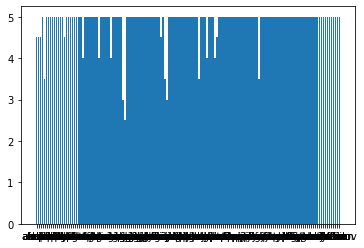

In [7]:
df_train['rating']
y_axis = df_train['rating']
x_axis = df_train['primary_label']
plt.bar(x_axis, y_axis)
plt.show()

In [8]:
df_submission.head()

,row_id,target
0,soundscape_1000170626_akiapo_5,False
1,soundscape_1000170626_akiapo_10,False
2,soundscape_1000170626_akiapo_15,False


In [9]:
#opening the scored bird file
with open('../input/birdclef-2022/scored_birds.json','r') as f:
    data = json.load(f)

In [10]:
print(data)

['akiapo', 'aniani', 'apapan', 'barpet', 'crehon', 'elepai', 'ercfra', 'hawama', 'hawcre', 'hawgoo', 'hawhaw', 'hawpet1', 'houfin', 'iiwi', 'jabwar', 'maupar', 'omao', 'puaioh', 'skylar', 'warwhe1', 'yefcan']


In [11]:
sample_rate, samples = wavfile.read('/kaggle/working/XC395771.wav')


In [12]:
len(samples)

871744

In [13]:
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

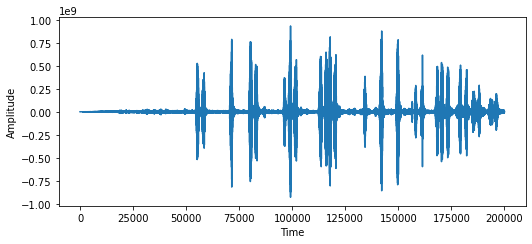

In [14]:
#Plotting Amplitude of a wav file against time
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
input_data = read("/kaggle/working/XC395771.wav")
audio = input_data[1]
plt.plot(audio[0:200000])#6seconds of video
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.show()

hypothesis: we need to consider the distancies between peaks with aproximately the same amplitude but only the ones which are close to each other, for example, the first two peaks that can be seeing in the image above. I think one of the features can be the average speed at which the bird repeat the same frequency. It is easier to understand when you listen the first 6 second of the audio and see the image above at the same time.

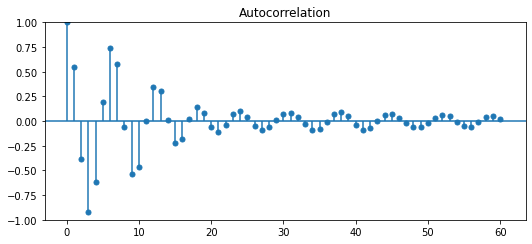

In [15]:
#Lets try to look for periodicity in this audio

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(audio)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

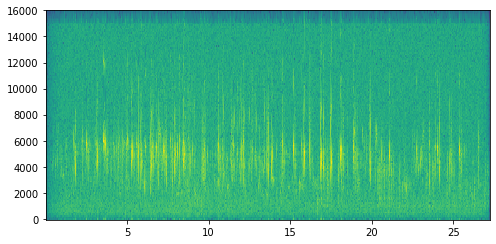

<Figure size 216x216 with 0 Axes>

In [16]:
#Creating an spectrogram of the same file
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
sample_rate, samples = wavfile.read('/kaggle/working/XC395771.wav')
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
plt.pcolormesh(times, frequencies, 10 * np.log10(spectrogram),shading = 'auto')
plt.figure(figsize = (3,3))

plt.show

In [17]:
#We calculate the discrete Fourier Transformation for our signal

fft_spectrum = np.fft.rfft(input_data[1])

In [18]:
fft_spectrum

array([ 14081006.               +0.j        ,
       -55112870.46310902+14860739.43745732j,
        -9218550.8361727  -8984545.7499299j , ...,
        -2780734.48171294  -372362.47420359j,
        -4229068.03072262   -24731.78713393j,
         2652726.               +0.j        ])

In [19]:
#range of frequencies
freq = np.fft.rfftfreq(input_data[1].size, d = 1./sample_rate)

In [20]:
fft_spectrum_abs = np.abs(fft_spectrum)

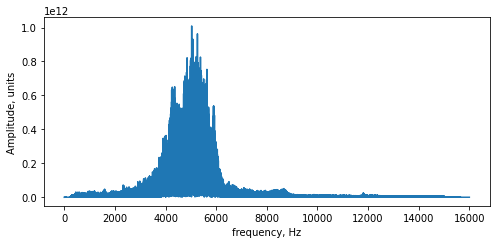

In [21]:
# we plot FFT
plt.plot(freq,fft_spectrum_abs)
plt.xlabel("frequency, Hz")
plt.ylabel("Amplitude, units")
plt.show()

Hypothesis:  We may fit a gaussian here and get sigma values. Depending on the bird we may fit more than one gaussian and get more than one sigma value.

In [22]:
np.shape(spectrogram)

(129, 3891)

In [23]:
len(frequencies)

129

In [24]:
len(times)

3891

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


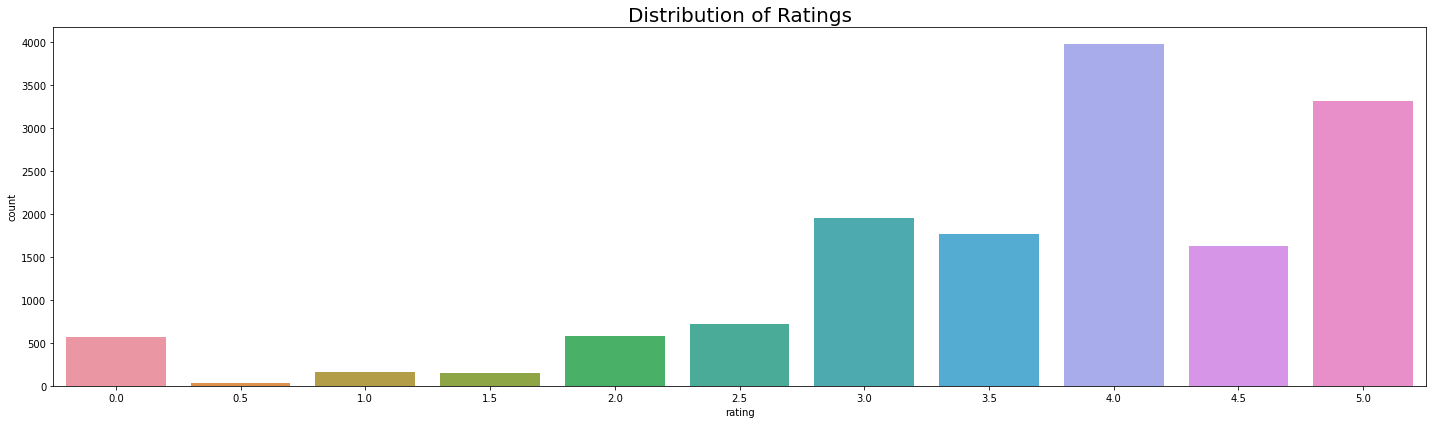

In [25]:
plt.figure(figsize=(20, 6))

sns.countplot(df_train['rating'])
plt.title("Distribution of Ratings", fontsize=20)

plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<function matplotlib.pyplot.show(close=None, block=None)>

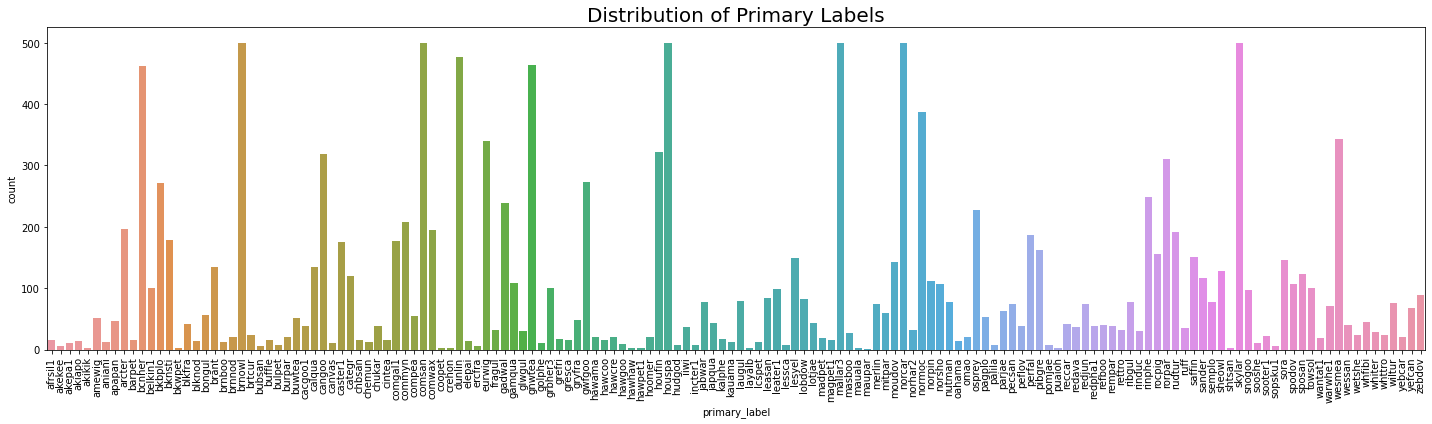

In [26]:
plt.figure(figsize=(20, 6))

sns.countplot(df_train['primary_label'])
plt.xticks(rotation=90)
plt.title("Distribution of Primary Labels", fontsize=20)

plt.show

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


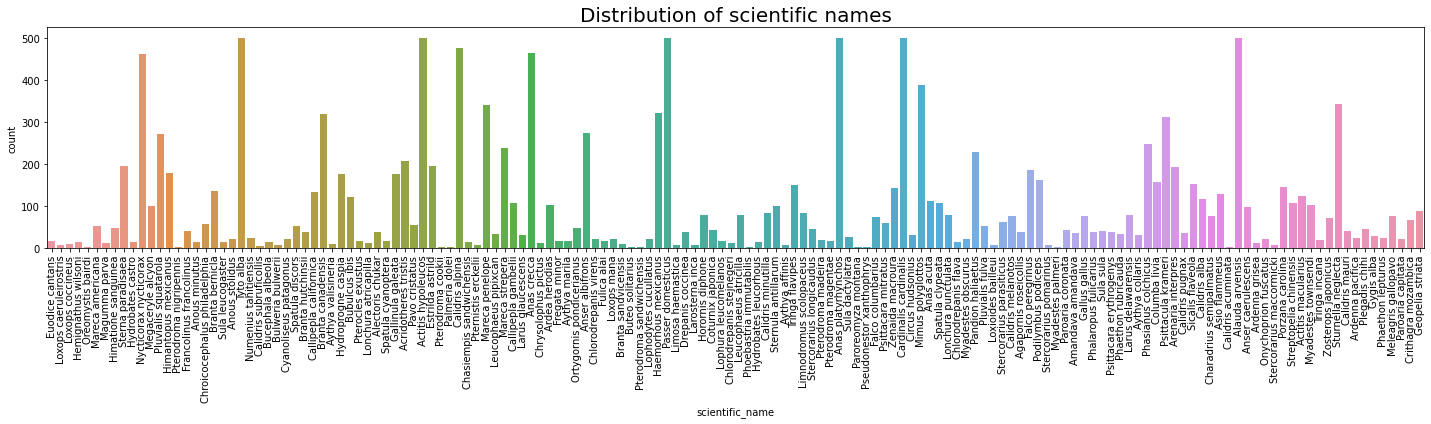

In [27]:
plt.figure(figsize=(20, 6))

sns.countplot(df_train['scientific_name'])
plt.xticks(rotation=90)
plt.title("Distribution of scientific names", fontsize=20)

plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


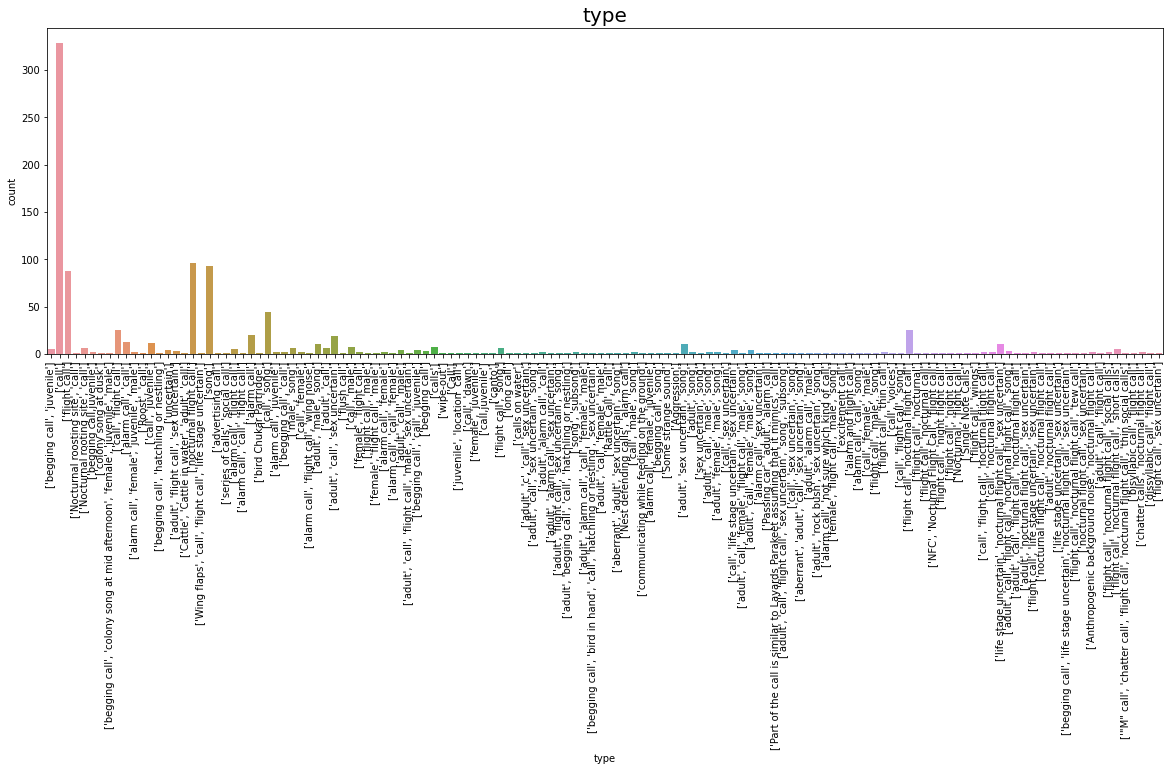

In [28]:
plt.figure(figsize=(20, 6))

sns.countplot(df_train['type'][3000:4000])
plt.xticks(rotation=90)
plt.title("type", fontsize=20)

plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


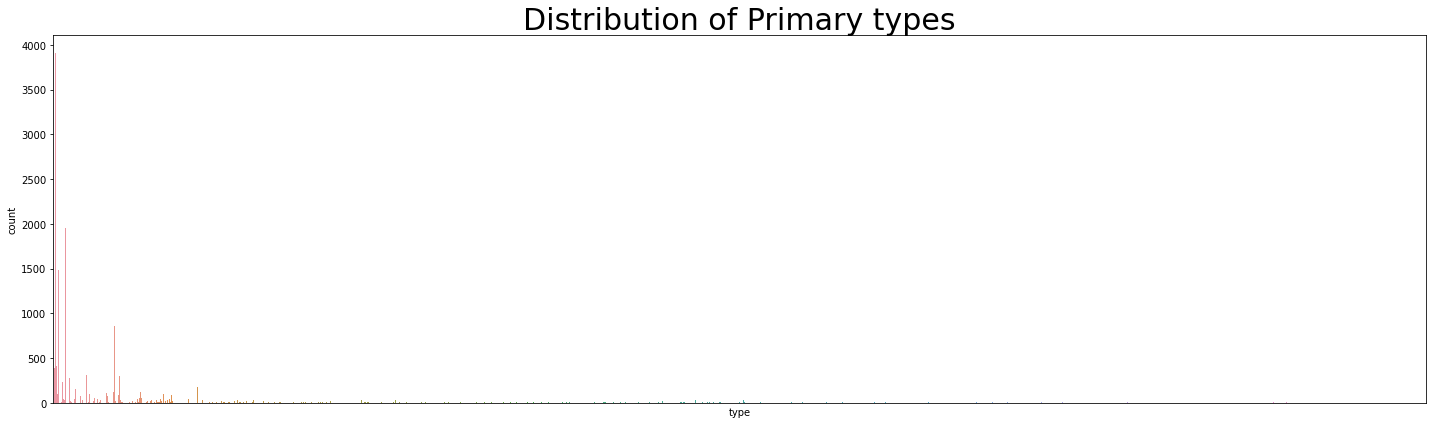

In [29]:
plt.figure(figsize=(20, 6))

sns.countplot(df_train['type'])
plt.title("Distribution of Primary types", fontsize=30)
plt.tick_params(axis = 'x', which = 'both', bottom = False,top = False, labelbottom = False )
plt.show()

In [30]:
#Elimino los elementos con un rating menor que 2.5, 
#lo que elimina tb los elementos que no tienen rating
#for i in df_train.index:
    #if df_train['rating'][i]<2.5:
       # df_train.drop([i],axis = 0, inplace = True)


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


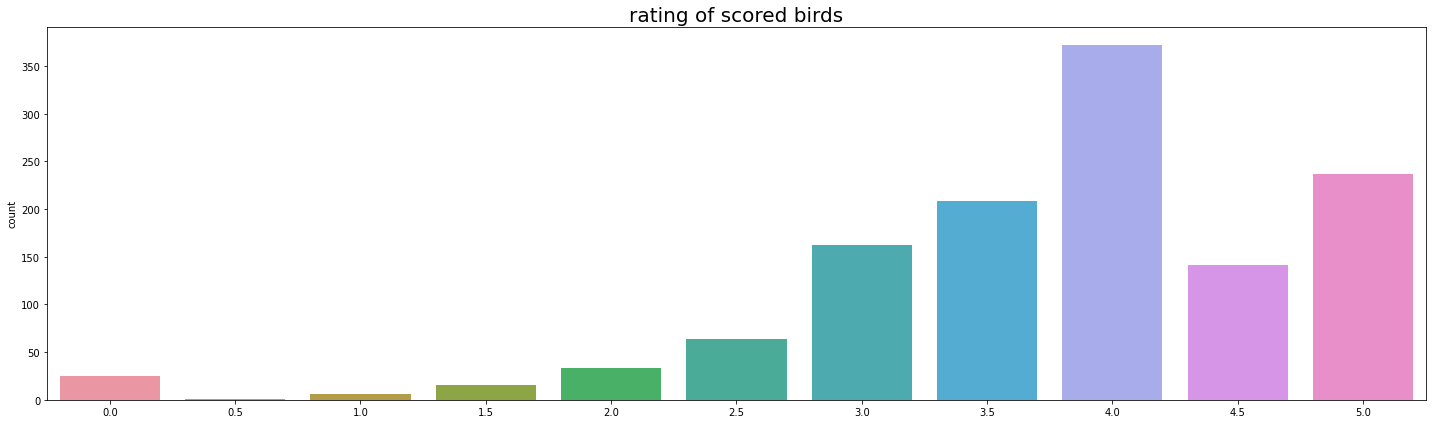

In [31]:
#Lets check the rating of the scored birds

index_row_scored = []
for i in data:
    a=i.strip('"')
    for j in range(len(df_train["primary_label"])):
        if df_train["primary_label"][j] == a:
            index_row_scored.append(j)
label_row_scored = []
for i in index_row_scored:
    label_row_scored.append(df_train["rating"][i])
    

plt.figure(figsize=(20, 6))
sns.countplot(label_row_scored)
plt.title("rating of scored birds", fontsize=20)

plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


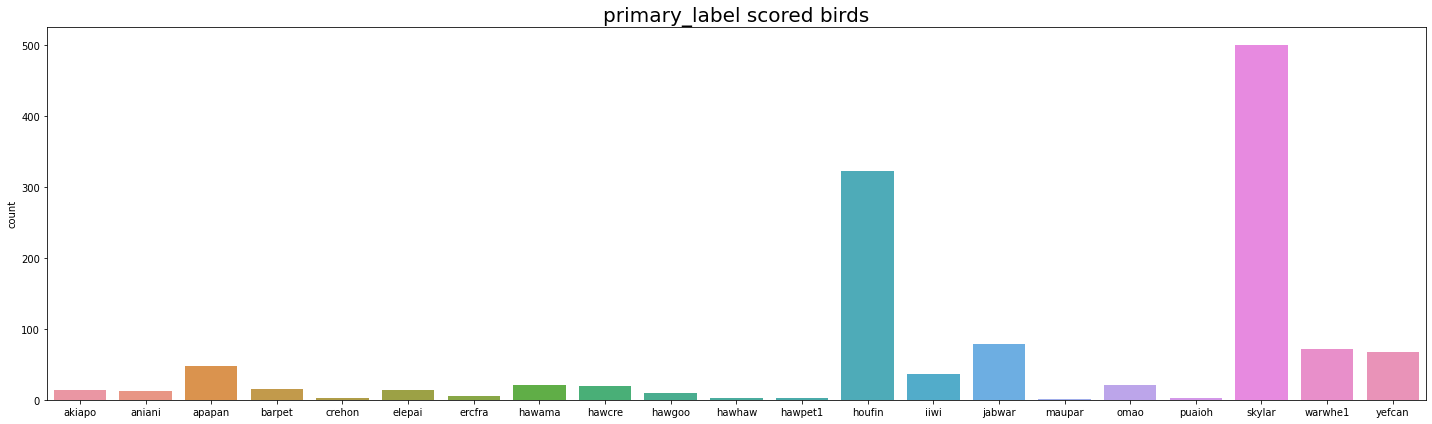

In [32]:
#let's check the primary_label of scored birds

label_row_scored = []
for i in index_row_scored:
    label_row_scored.append(df_train["primary_label"][i])
    

plt.figure(figsize=(20, 6))
sns.countplot(label_row_scored)
plt.title("primary_label scored birds", fontsize=20)

plt.show()

List with the rated audios:

In [33]:

from os import listdir
from os.path import isfile, join
rated_list = []
for i in data:
    onlyfiles = [f for f in listdir("../input/birdclef-2022/train_audio/"+i) if isfile(join("../input/birdclef-2022/train_audio/"+i,f))]
    rated_list.append(i)
    rated_list.append(onlyfiles)
    

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


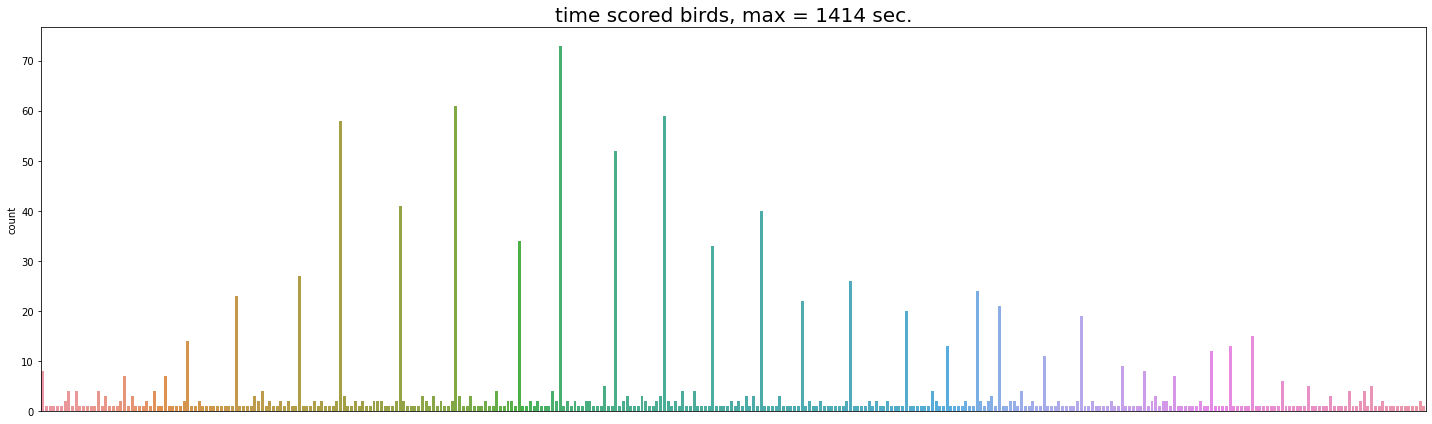

In [34]:
#Distribution of time of each scored audio
#Times goes from 0 to max(time_row_scored)=1414 sec.
counter = 0
time_row_scored = []
for i in index_row_scored:
    counter = counter +1
    if df_train["time"][i][0] not in ["?","x"] and df_train["time"][i][1] not in [":"]:
        time = int(df_train["time"][i][0])*10*60 + int(df_train["time"][i][1])*60 + int(df_train["time"][i][3])*10 +int(df_train["time"][i][4])
        time_row_scored.append(time)
    elif df_train["time"][i][0] not in ["?","x"]:
        time = int(df_train["time"][i][0])*60 + int(df_train["time"][i][2])*10 +int(df_train["time"][i][3])
        time_row_scored.append(time)
        
    
plt.figure(figsize=(20, 6))
sns.countplot(time_row_scored)
plt.title("time scored birds, max = 1414 sec.", fontsize=20)
plt.tick_params(axis = 'x', which = 'both', bottom = False,top = False, labelbottom = False )
plt.xticks(rotation=90)

plt.show()

In [35]:
#Let's calculate how many seconds of audio we have for each scored bird if possible and 
#let save it in a dictionary

counter = 0
time_row_scored = []
for i in index_row_scored:
    counter = counter +1
    if df_train["time"][i][0] not in ["?","x"] and df_train["time"][i][1] not in [":"]:
        time = int(df_train["time"][i][0])*10*60 + int(df_train["time"][i][1])*60 + int(df_train["time"][i][3])*10 +int(df_train["time"][i][4])
        time_row_scored.append(time)
    elif df_train["time"][i][0] not in ["?","x"]:
        time = int(df_train["time"][i][0])*60 + int(df_train["time"][i][2])*10 +int(df_train["time"][i][3])
        time_row_scored.append(time)
    else:
        time_row_scored.append(['Undefined'])


    

In [36]:
from collections import defaultdict
label_row_scored.sort()
outputlist = defaultdict(list)
for A, B in zip(label_row_scored, time_row_scored):
    outputlist[A].append(B)
time_scored_sum = []
for i in data:
    try:
        suma = sum(outputlist[i])
        time_scored_sum.append(suma)
    except:
        time_scored_sum.append(["?"])

In [37]:
dict_species_time = dict(zip(data,time_scored_sum))

In [38]:
dict_species_time

{'akiapo': 11671,
 'aniani': 8360,
 'apapan': 29820,
 'barpet': 18374,
 'crehon': 1157,
 'elepai': 9790,
 'ercfra': 2966,
 'hawama': 15575,
 'hawcre': 15832,
 'hawgoo': 7040,
 'hawhaw': 2373,
 'hawpet1': 3704,
 'houfin': ['?'],
 'iiwi': 23748,
 'jabwar': ['?'],
 'maupar': 738,
 'omao': 11694,
 'puaioh': 2010,
 'skylar': ['?'],
 'warwhe1': ['?'],
 'yefcan': ['?']}

In [39]:
# As there are not so many scored birds, it can be interesting to get spectrograms of 
#high quality audios, and listen those audios while we check the frequencies, intensities, etc
#df_high = df_train
#for i in df_high.index:
    #if df_high['rating'][i]<3.5:
        #df_high.drop([i],axis = 0, inplace = True)

In [40]:
#for j in data:
   # for i in df_high.index:
        #if df_high['primary_label'][i]==j:
            #print(df_high['filename'][i])
#label_row_scored

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


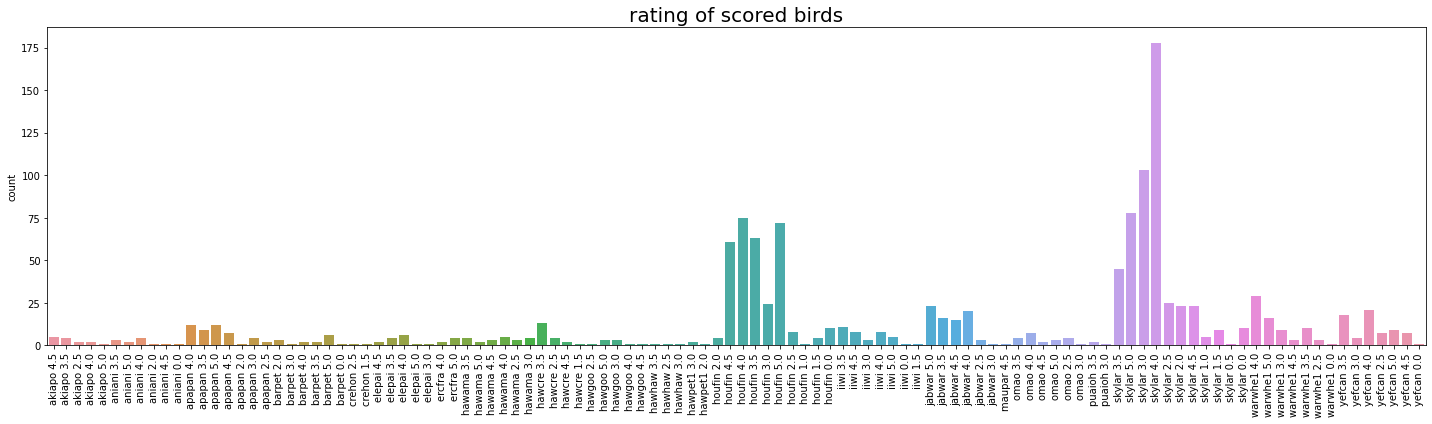

In [41]:
#we can try to find how many audios we have of each scored species and check the rating of
# them, for crehon for example, there are only 2 audios and with low quality.
scoredbird_rating = []
for i in index_row_scored:
    try:
        scoredbird_rating.append(str(df_train['primary_label'][i])+ " " +str(df_train['rating'][i]))
    except:
        print('error')
scoredbird_rating
plt.figure(figsize=(20, 6))
sns.countplot(scoredbird_rating)
plt.xticks(rotation=90)
plt.title("rating of scored birds", fontsize=20)

plt.show()


we can see that for crahon the best rating is 2.5, for puaioh 3.5. there are many species with not so many audios, for example omao, puaioh, crahon...

In [42]:
# with scorebird_rating.index('bird rating') we can localize the index for the best rating of each bird
scoredbird_rating.index('akiapo 5.0')

10

In [43]:
#to find them in the dataset we write the indexes on index_row_scored
index_row_scored[10]

42

In [44]:
print(str(df_train['primary_label'][42]) + ' ' + str(df_train['rating'][42]))

akiapo 5.0


In [45]:
print(str(df_train['filename'][42]))

akiapo/XC306424.ogg


In [46]:
#the list with the indexes like line [80] is

indexes = [10,17,30,78,88,97,105,111,138,152,160,163,175,501,525,603,611,625,629,1129,1205]

In [47]:
#let's get our data from the dataframe
indexes_high_rate = []
for i in indexes:
    indexes_high_rate.append(index_row_scored[i])

print(df_train['primary_label'][indexes_high_rate], df_train['rating'][indexes_high_rate])

    
    

42        akiapo
102       aniani
115       apapan
359       barpet
4302      crehon
4787      elepai
4795      ercfra
6479      hawama
6522      hawcre
6536      hawgoo
6544      hawhaw
6547     hawpet1
6579      houfin
7413        iiwi
7445      jabwar
8721      maupar
10232       omao
11064     puaioh
12896     skylar
14028    warwhe1
14702     yefcan
Name: primary_label, dtype: object 42       5.0
102      5.0
115      5.0
359      5.0
4302     2.5
4787     5.0
4795     5.0
6479     5.0
6522     4.5
6536     5.0
6544     3.5
6547     3.0
6579     5.0
7413     5.0
7445     5.0
8721     4.5
10232    4.5
11064    3.5
12896    5.0
14028    5.0
14702    5.0
Name: rating, dtype: float64


[[ 17260  58119]
 [-60749 -29850]
 [-36259 -11703]
 ...
 [  3738  -1281]
 [ -8997 -17722]
 [ -4334 -12304]]


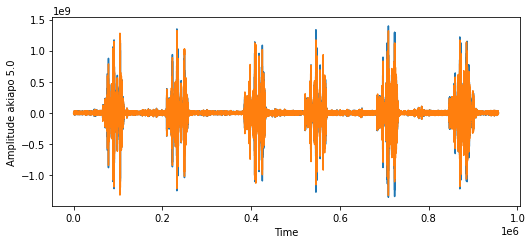

[[   927   9941]
 [-12454 -15278]
 [ 10030 -10508]
 ...
 [ -7186   9405]
 [-17542    569]
 [ -5080  17592]]


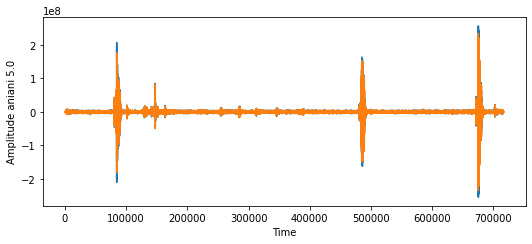

[ -1819   3848 -18640 ... -62915 275534 140544]


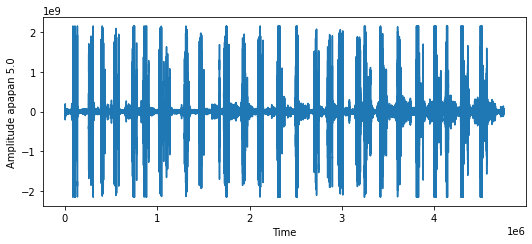

[  -16910   -62685      506 ... 13727468  9767640  7493745]


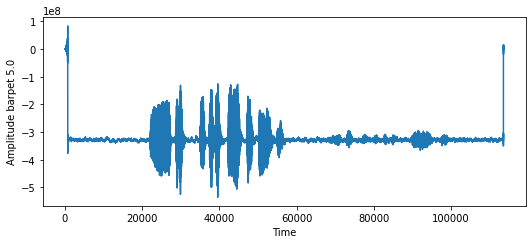

[[  -28242   -62231]
 [  -17075   -46525]
 [  -17517   -55595]
 ...
 [  -30218   482833]
 [-1587246 -1303263]
 [   82822  -854425]]


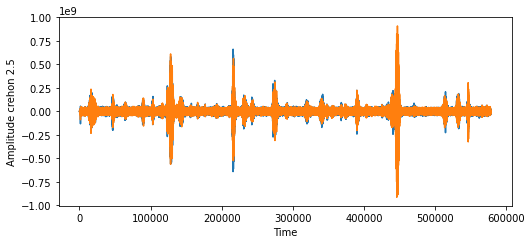

[-5854 -2758 59505 ... -6493  5115   748]


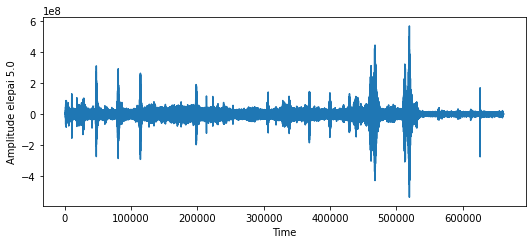

[[-36888  20135]
 [  5908  34487]
 [ 88668  86230]
 ...
 [  5860   9642]
 [  -939  -5628]
 [  -642  -3142]]


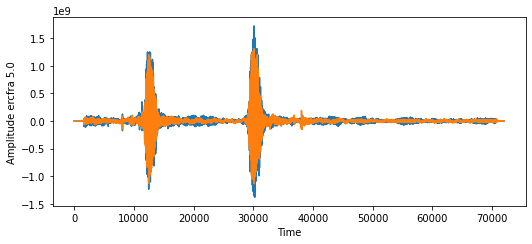

[ -3120  20545  -3630 ...   1816   9858 -13796]


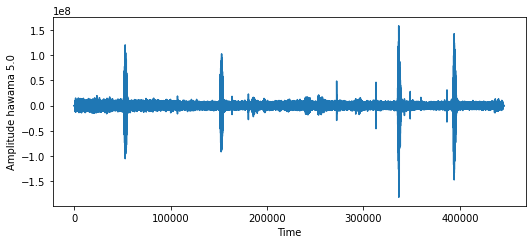

[[-46051 -27246]
 [ 14780  13572]
 [ -1965 -15538]
 ...
 [   308    135]
 [   -76    797]
 [  -123   1205]]


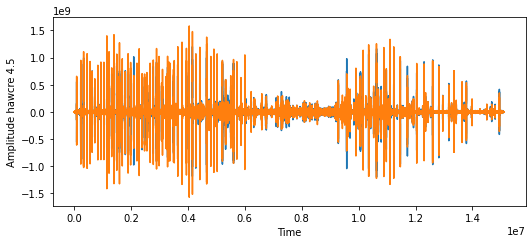

[[   9013    4313]
 [   5013   -9482]
 [  -1363  -27967]
 ...
 [2826039  825901]
 [3429432 1576045]
 [1403199 -399445]]


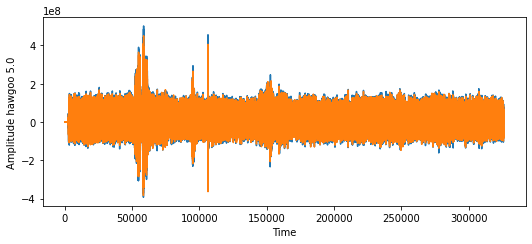

[[ 30256  48111]
 [-22352 -35788]
 [ -2534   -317]
 ...
 [  5456   9414]
 [  5102  32849]
 [ 10403  30032]]


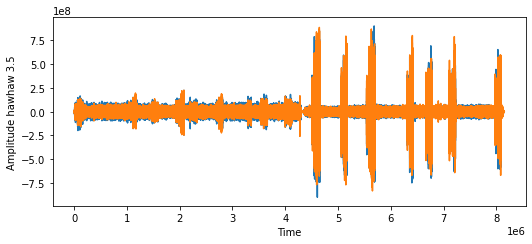

[-77143  -5196 -55581 ...  -1483   -996   -372]


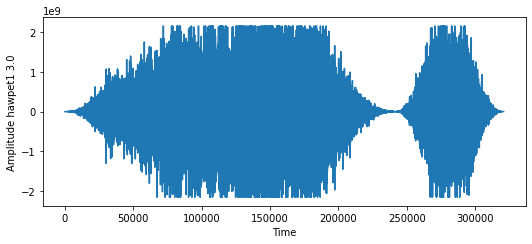

[[ 21564  62117]
 [  9933  47225]
 [-19661   2720]
 ...
 [  9767  21818]
 [ -8778   4490]
 [  -674  15847]]


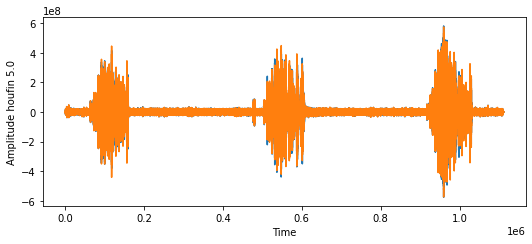

[ 49582   4498 -34531 ...      1     -1      0]


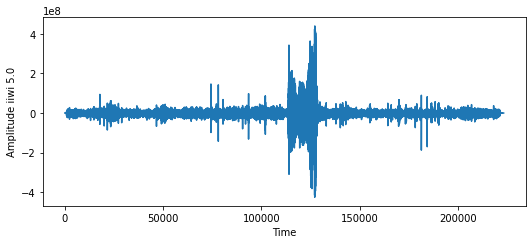

[[  1083 -16321]
 [-23526 -68767]
 [ 29227  -9179]
 ...
 [     2      1]
 [     0     -1]
 [     0      0]]


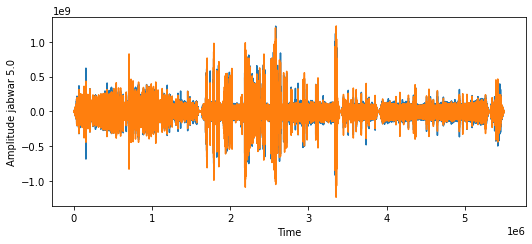

[[ 72769  63875]
 [  2107   5879]
 [-12801  -2098]
 ...
 [-33766 -13556]
 [ -9364  -2932]
 [ 12862  -3401]]


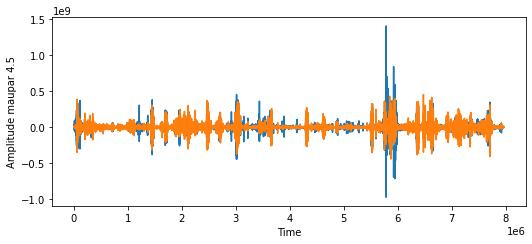

[-5848  2790 -8053 ...   529   194  -928]


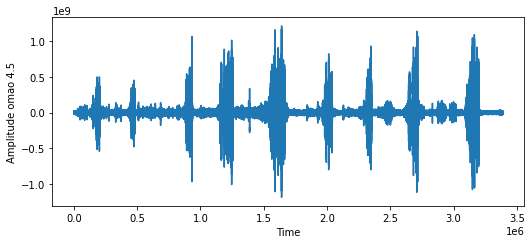

[-59009 -10108  -2232 ...  32570  40716  13963]


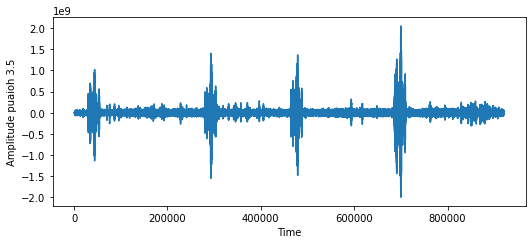

[-6839   613 -6308 ... -2638  2821  2334]


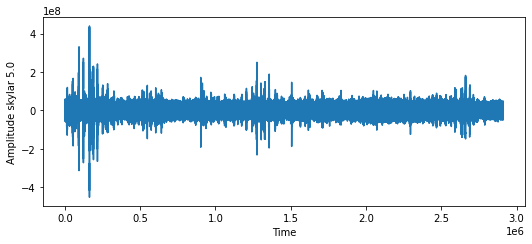

[-16663  70792   7037 ...  -8642  -1834   7962]


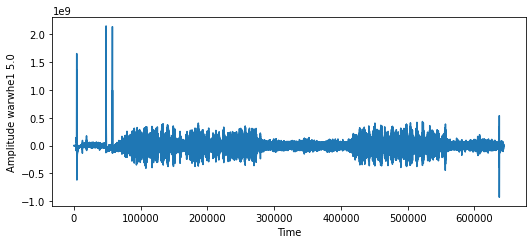

[[  19399   36068]
 [  26892   50328]
 [ -63071  -68410]
 ...
 [-276434 1853790]
 [-279332 1409572]
 [ 207900 1369016]]


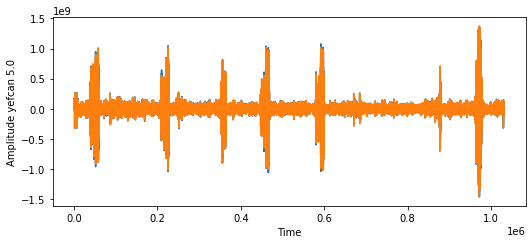

In [48]:
#Let's loop our first code with the random audio but for our list of rated birds
for i in indexes_high_rate:
    src = "../input/birdclef-2022/train_audio/" + str(df_train['filename'][i])
    dst = "/kaggle/working/" + str(df_train['primary_label'][i]) + ".wav"

# convert ogg to wav
    sound = AudioSegment.from_ogg(src)
    sound.export(dst, format="wav")
    
    plt.rcParams["figure.figsize"] = [7.50, 3.50]
    plt.rcParams["figure.autolayout"] = True
    input_data = read(dst)
    audio = input_data[1]
    print(audio)
    plt.plot(audio)
    plt.ylabel("Amplitude"+' ' +str(df_train['primary_label'][i]) + ' ' + str(df_train['rating'][i]))
    plt.xlabel("Time")
    plt.show()


In [49]:
#in some cases we have multiple signal. I guess we have stereo and mono audios.